In [17]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Load the Excel File and Read Sheets
file_path = 'Solubility_Dataset.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load individual sheets
solubility_data = excel_data.parse('Solubility')
drugs_data = excel_data.parse('Drugs')
solvents_data = excel_data.parse('Solvents')

# Step 2: Clean Data

# Remove extras
solubility_data = solubility_data.drop(columns=['DOI', 'Web of Science Index'])
drugs_data = drugs_data.drop(columns = ['CAS', 'Source_1', 'Source_2', 'Drugs@FDA', 'Melting_temp (C)'])
solvents_data = solvents_data.drop(columns = ['CAS', 'Source_1', 'Melting_temp (C)'])



print(drugs_data.head())  # Display the first 5 rows



# Save cleaned data
solubility_data.to_csv('solubility.csv', index=False)
drugs_data.to_csv('drugs.csv', index=False)
solvents_data.to_csv('solvents.csv', index=False)

                        Drug  \
0    Guanidine hydrochloride   
1  Glucosamine hydrochloride   
2   2-Amino-6-chloropyrazine   
3           Thiamine nitrate   
4               Aripiprazole   

                                              SMILES  Melting_temp (K)  
0                                         Cl.N=C(N)N           451.150  
1                           Cl.O=CC(N)C(O)C(O)C(O)CO           491.007  
2                                   ClC=1N=C(N)C=NC1           426.150  
3     O=N(=O)[O-].OCCC=1SC=[N+](C1C)CC2=CN=C(N=C2N)C           471.150  
4  O=C1NC2=CC(OCCCCN3CCN(C=4C=CC=C(Cl)C4Cl)CC3)=C...           383.150  


In [18]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load Dataset
drugs_data = pd.read_csv('drugs.csv')
solvents_data = pd.read_csv('solvents.csv')

# Molecular Descriptor Calculation
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        mw = Descriptors.MolWt(mol)  # Molecular Weight
        logp = Descriptors.MolLogP(mol)  # LogP
        tpsa = Descriptors.TPSA(mol)  # Topological Polar Surface Area
        rb = Descriptors.NumRotatableBonds(mol)  # Rotatable Bonds
        hbd = Descriptors.NumHDonors(mol)  # Hydrogen Bond Donors
        hba = Descriptors.NumHAcceptors(mol)  # Hydrogen Bond Acceptors
        num_aromatic_rings = rdMolDescriptors.CalcNumAromaticRings(mol)  # Aromatic Rings
        return pd.Series([mw, logp, tpsa, rb, hbd, hba, num_aromatic_rings])
    else:
        return pd.Series([None, None, None, None, None, None, None])

# Generate descriptors for all molecules
drugs_data[['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']] = drugs_data['SMILES'].apply(calculate_descriptors)
solvents_data[['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']] = solvents_data['SMILES'].apply(calculate_descriptors)

solubility_data.to_csv('solubility1.csv', index=False)
drugs_data.to_csv('drugs1.csv', index=False)
solvents_data.to_csv('solvents1.csv', index=False)

print(drugs_data.head())  # Display the first 5 rows
print(solvents_data.head())  # Display the first 5 rows

                        Drug  \
0    Guanidine hydrochloride   
1  Glucosamine hydrochloride   
2   2-Amino-6-chloropyrazine   
3           Thiamine nitrate   
4               Aripiprazole   

                                              SMILES  Melting_temp (K)  \
0                                         Cl.N=C(N)N           451.150   
1                           Cl.O=CC(N)C(O)C(O)C(O)CO           491.007   
2                                   ClC=1N=C(N)C=NC1           426.150   
3     O=N(=O)[O-].OCCC=1SC=[N+](C1C)CC2=CN=C(N=C2N)C           471.150   
4  O=C1NC2=CC(OCCCCN3CCN(C=4C=CC=C(Cl)C4Cl)CC3)=C...           383.150   

     MolWt     LogP    TPSA  NumRotatableBonds  NumHDonors  NumHAcceptors  \
0   95.533 -0.73963   75.89                0.0         3.0            1.0   
1  215.633 -2.99060  124.01                5.0         5.0            6.0   
2  129.550  0.71220   51.80                0.0         1.0            3.0   
3  327.366  0.36864  142.11                4.0        

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load Data
solubility = pd.read_csv('solubility1.csv')
drugs = pd.read_csv('drugs1.csv')
solvents = pd.read_csv('solvents1.csv')

# Merge solubility with drugs and solvents
data = solubility.merge(drugs, left_on='Drug', right_on='Drug')
data = data.merge(solvents, how='left', left_on='Solvent_1', right_on='Solvent', suffixes=('', '_solvent1'))
data = data.merge(solvents, how='left', left_on='Solvent_2', right_on='Solvent', suffixes=('', '_solvent2'))

data.to_csv('merged_solubility.csv', index=False)
print(data.tail())
# Step 2: Feature Engineering
# Select relevant columns from drugs and solvents
drug_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']
solvent_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']



          Drug Solvent_1  Solvent_1_weight_fraction  Solvent_1_mol_fraction  \
28698  Aspirin   Ethanol                        0.5                     NaN   
28699  Aspirin   Ethanol                        0.8                     NaN   
28700  Aspirin   Ethanol                        0.2                     NaN   
28701  Aspirin   Ethanol                        0.5                     NaN   
28702  Aspirin   Ethanol                        0.8                     NaN   

      Solvent_2  Temperature (K)  Solubility (mol/mol)  \
28698     Water           298.15              0.015803   
28699     Water           298.15              0.046089   
28700     Water           313.15              0.002981   
28701     Water           313.15              0.029540   
28702     Water           313.15              0.062436   

                         SMILES  Melting_temp (K)    MolWt  ...  \
28698  O=C(O)C=1C=CC=CC1OC(=O)C            408.15  180.159  ...   
28699  O=C(O)C=1C=CC=CC1OC(=O)C           

Random Forest CV RMSE: 0.037
Gradient Boosting CV RMSE: 0.042
Random Forest Test RMSE: 0.036, R2: 0.770
Gradient Boosting Test RMSE: 0.043, R2: 0.674


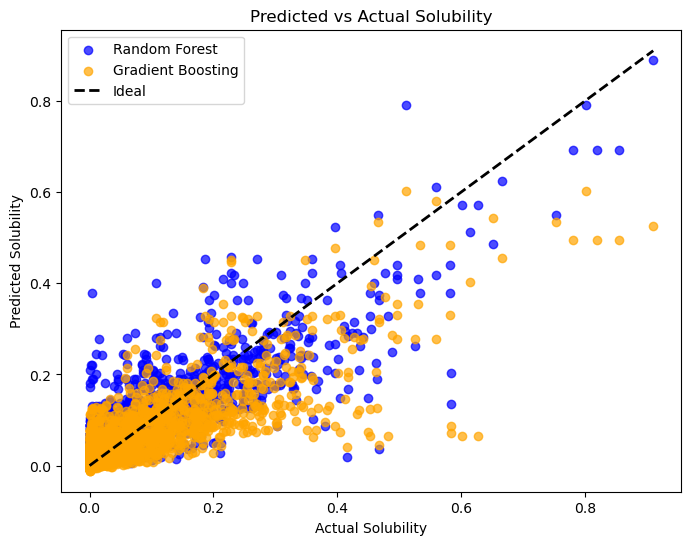

In [117]:
# Combine all features
X = pd.concat([
    data[drug_features],  # Drug descriptors
    data[[f"{feat}_solvent1" for feat in solvent_features]],  # Solvent1 descriptors
    data[[f"{feat}_solvent2" for feat in solvent_features]],  # Solvent2 descriptors
    data[['Temperature (K)']]  # Temperature
], axis=1)

y = data['Solubility (mol/mol)']  # Target variable

# Step 3: Normalize Numerical Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Model Training
# Random Forest
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Gradient Boosting
gbm_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gbm_model.fit(X_train, y_train)

# Step 6: Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_cv_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
gbm_cv_scores = cross_val_score(gbm_model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')

print(f"Random Forest CV RMSE: {np.sqrt(-rf_cv_scores).mean():.3f}")
print(f"Gradient Boosting CV RMSE: {np.sqrt(-gbm_cv_scores).mean():.3f}")

# Step 7: Model Evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_gbm = gbm_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
gbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
gbm_r2 = r2_score(y_test, y_pred_gbm)

print(f"Random Forest Test RMSE: {rf_rmse:.3f}, R2: {rf_r2:.3f}")
print(f"Gradient Boosting Test RMSE: {gbm_rmse:.3f}, R2: {gbm_r2:.3f}")

# Step 8: Visualization
# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_gbm, alpha=0.7, label='Gradient Boosting', color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.legend()
plt.title("Predicted vs Actual Solubility")
plt.show()

In [103]:
import pandas as pd

# Load the dataset
data = pd.read_csv('merged_solubility.csv')

# Function to calculate mole fraction of solvent1 given the weight fraction
def weight_to_mole_fraction(weight_fraction, mol_weight_solvent1, mol_weight_solvent2):
    mole_solvent1 = weight_fraction / mol_weight_solvent1
    mole_solvent2 = (1 - weight_fraction) / mol_weight_solvent2
    mole_fraction_solvent1 = mole_solvent1 / (mole_solvent1 + mole_solvent2)
    return mole_fraction_solvent1

# Function to calculate weight fraction of solvent1 given the mole fraction
def mole_to_weight_fraction(mole_fraction, mol_weight_solvent1, mol_weight_solvent2):
    weight_solvent1 = mole_fraction * mol_weight_solvent1
    weight_solvent2 = (1 - mole_fraction) * mol_weight_solvent2
    total_weight = weight_solvent1 + weight_solvent2
    weight_fraction_solvent1 = weight_solvent1 / total_weight
    return weight_fraction_solvent1
    
# Iterate through rows and fill missing mole fractions
for index, row in data.iterrows():
    if pd.isna(row['Solvent_1_mol_fraction']):
        wf = row['Solvent_1_weight_fraction']  # Weight fraction
        mw_solvent_1 = row['MolWt_solvent1']   # Molecular weight of solvent 1
        mw_solvent_2 = row['MolWt_solvent2']   # Molecular weight of solvent 2
        
        # Calculate mole fraction
        mole_fraction = weight_to_mole_fraction(wf, mw_solvent_1, mw_solvent_2)
        
        # Update the DataFrame safely using .loc
        data.loc[index, 'Solvent_1_mol_fraction'] = mole_fraction

for index, row in data.iterrows():
    if pd.isna(row['Solvent_1_weight_fraction']):
        mf = row['Solvent_1_mol_fraction']  # Weight fraction
        mw_solvent_1 = row['MolWt_solvent1']   # Molecular weight of solvent 1
        mw_solvent_2 = row['MolWt_solvent2']   # Molecular weight of solvent 2
        
        # Calculate weight fraction
        weight_fraction = weight_to_mole_fraction(mf, mw_solvent_1, mw_solvent_2)
        
        # Update the DataFrame safely using .loc
        data.loc[index, 'Solvent_1_weight_fraction'] = weight_fraction

data.to_csv('merged_solubility_value.csv', index=False)
    

                      Drug          Solvent_1  Solvent_1_weight_fraction  \
0  Guanidine hydrochloride  Dimethylformamide                     0.1001   
1  Guanidine hydrochloride  Dimethylformamide                     0.1001   
2  Guanidine hydrochloride  Dimethylformamide                     0.1001   
3  Guanidine hydrochloride  Dimethylformamide                     0.1001   
4  Guanidine hydrochloride  Dimethylformamide                     0.1001   

   Solvent_1_mol_fraction   Solvent_2  Temperature (K)  Solubility (mol/mol)  \
0                 0.08379  1-Propanol           278.15               0.06940   
1                 0.08379  1-Propanol           283.15               0.07705   
2                 0.08379  1-Propanol           288.15               0.08496   
3                 0.08379  1-Propanol           293.15               0.09085   
4                 0.08379  1-Propanol           298.15               0.09774   

       SMILES  Melting_temp (K)   MolWt  ...  Solvent_solvent2

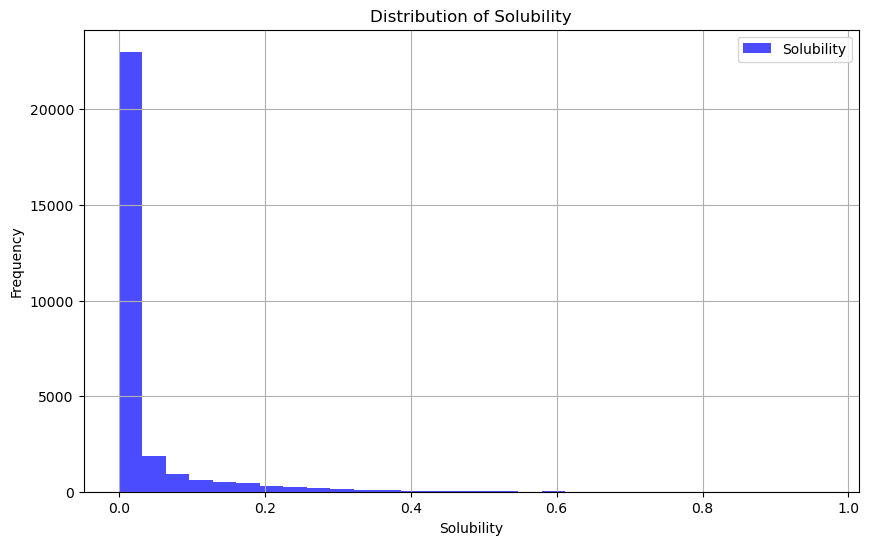

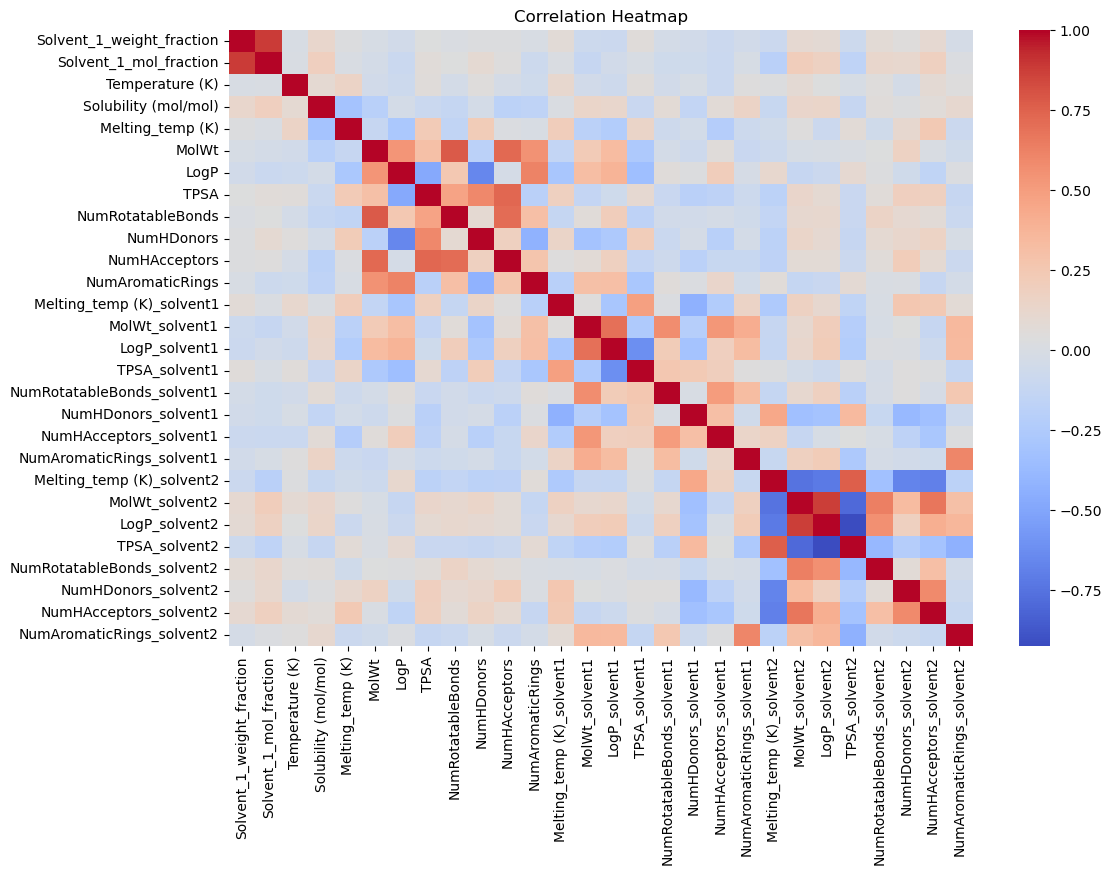

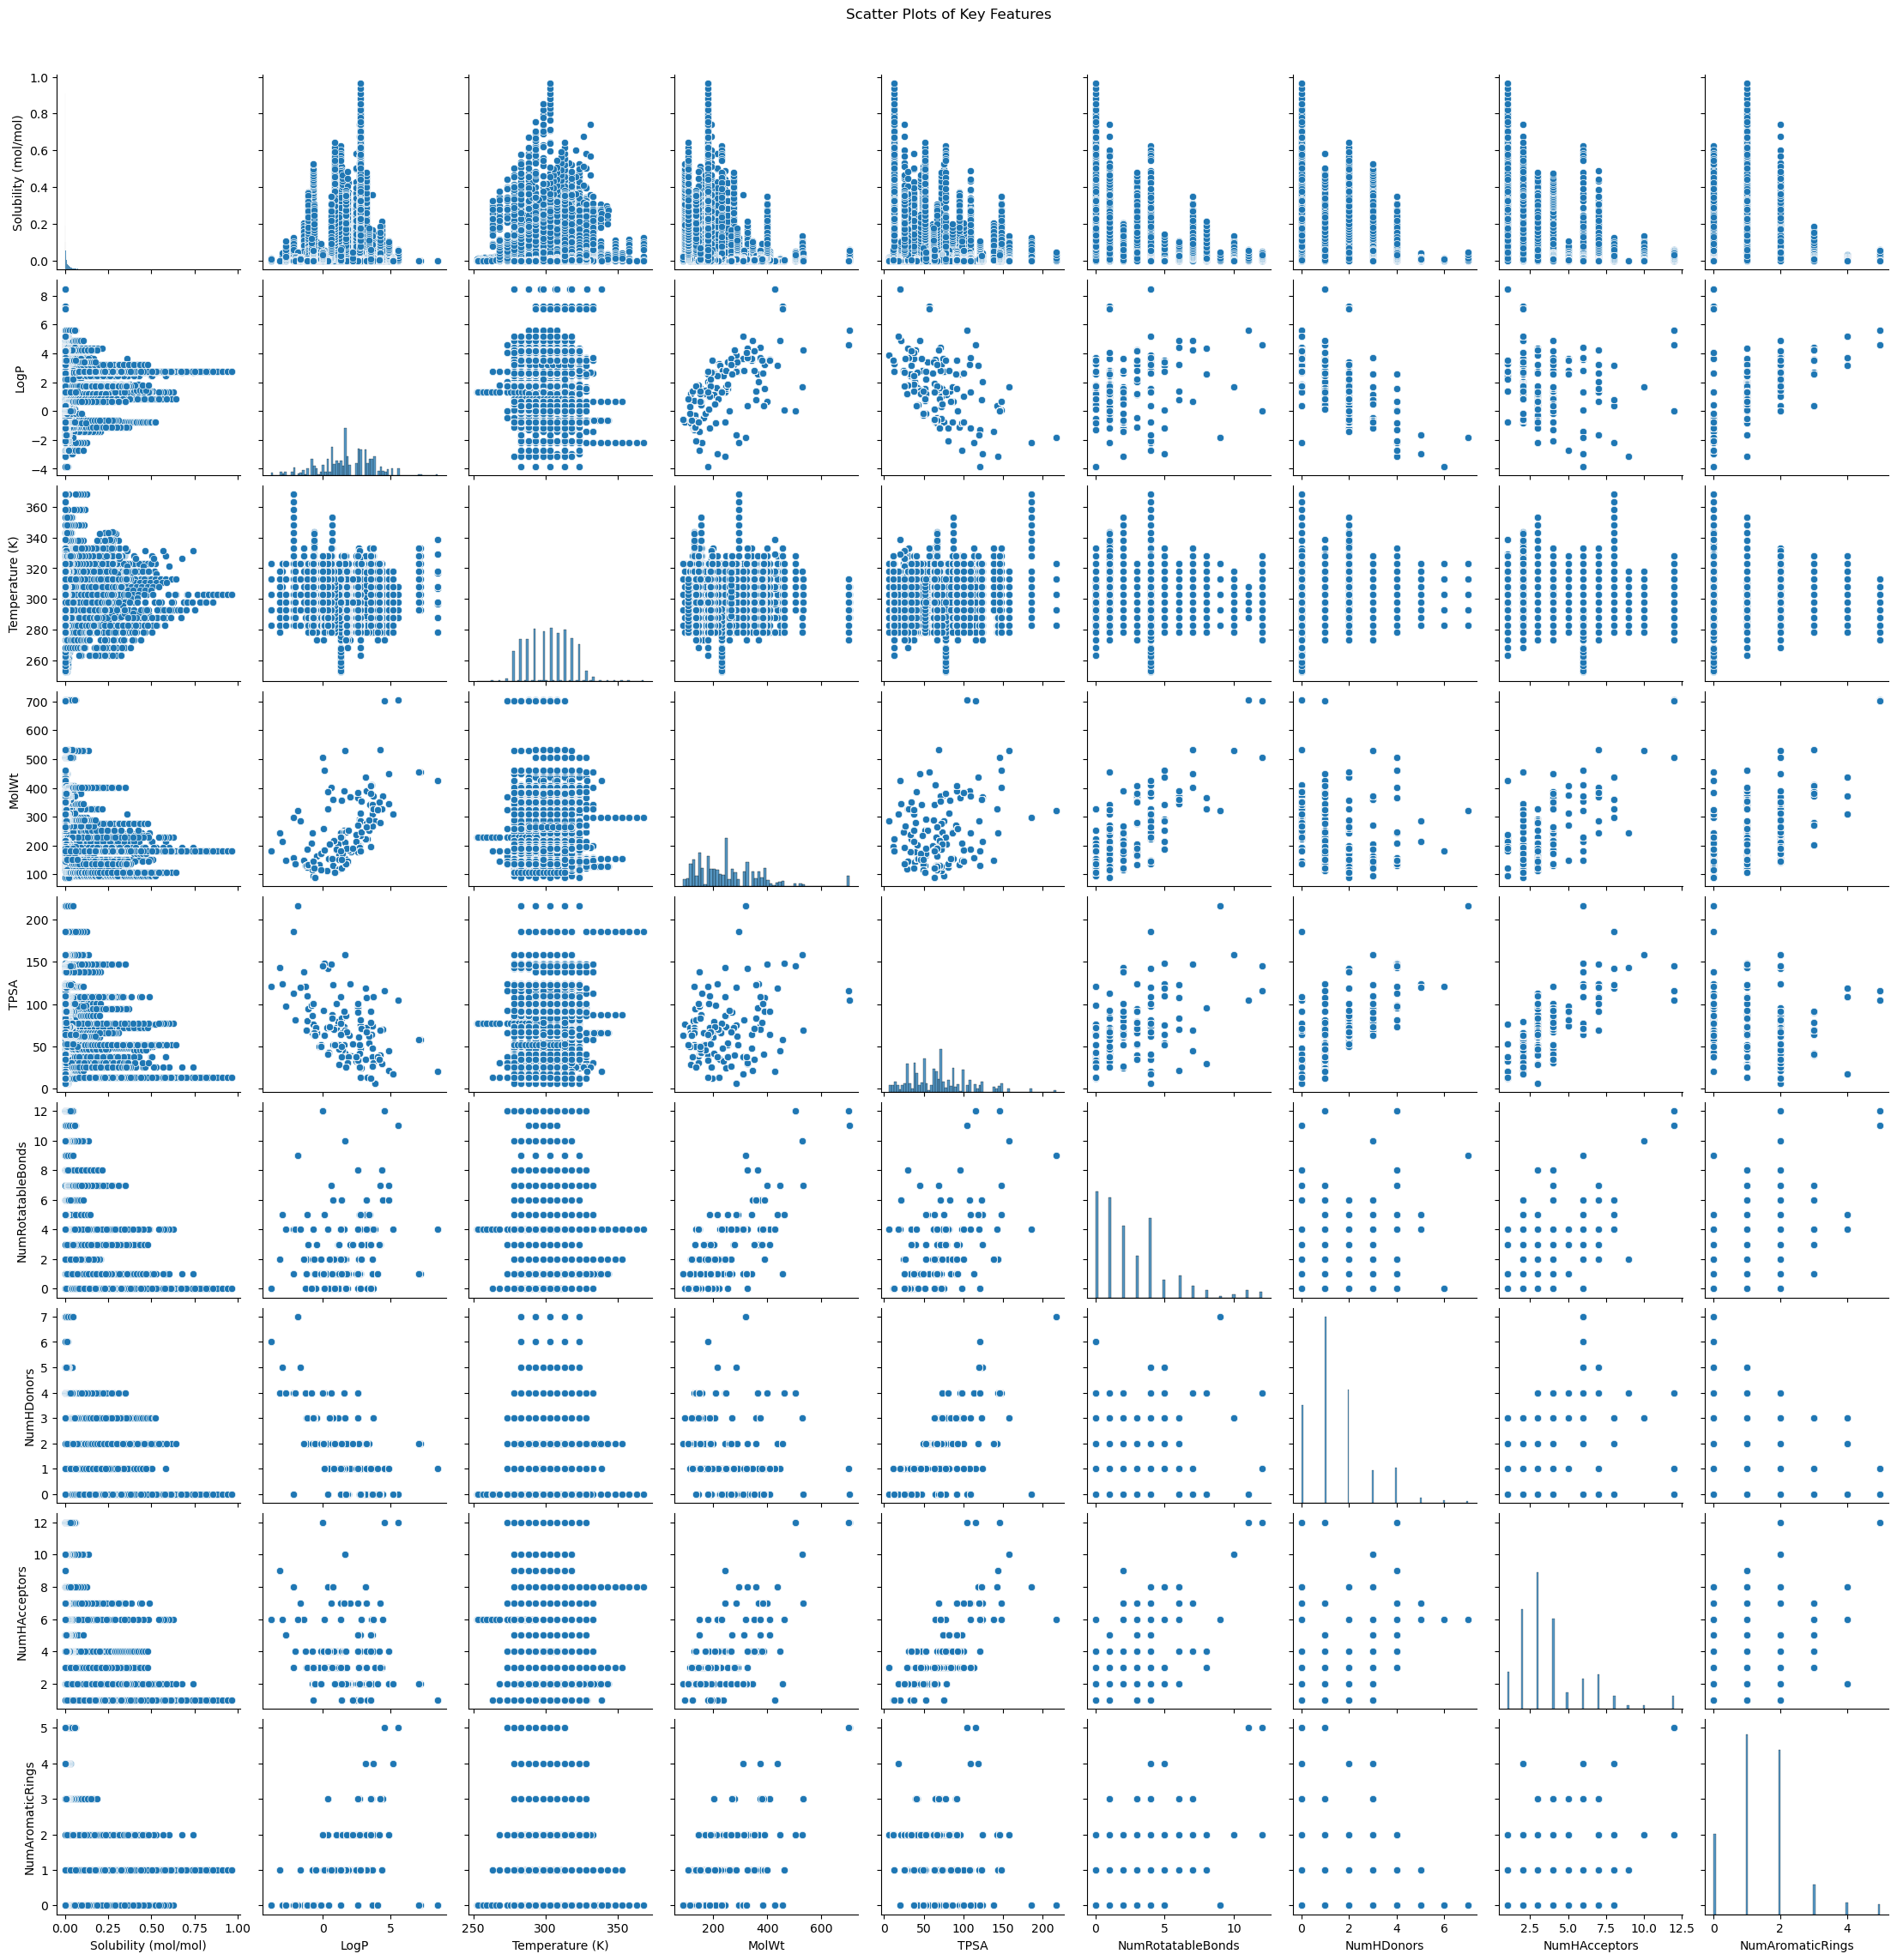

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load Merged Dataset
data = pd.read_csv('merged_solubility_value.csv')
print(data.head())
# Step 1: EDA
# Visualize distributions
plt.figure(figsize=(10, 6))
data['Solubility (mol/mol)'].hist(bins=30, alpha=0.7, color='blue', label='Solubility')
plt.xlabel('Solubility')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility')
plt.legend()
plt.show()

# Correlation heatmap
data_numeric = data.select_dtypes(include=[float, int])
correlation_matrix = data_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()

# Scatter plot of solubility vs key features
sns.pairplot(data, vars=['Solubility (mol/mol)', 'LogP', 'Temperature (K)', 'MolWt', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings'])
plt.suptitle('Scatter Plots of Key Features', y=1.02)
plt.show()



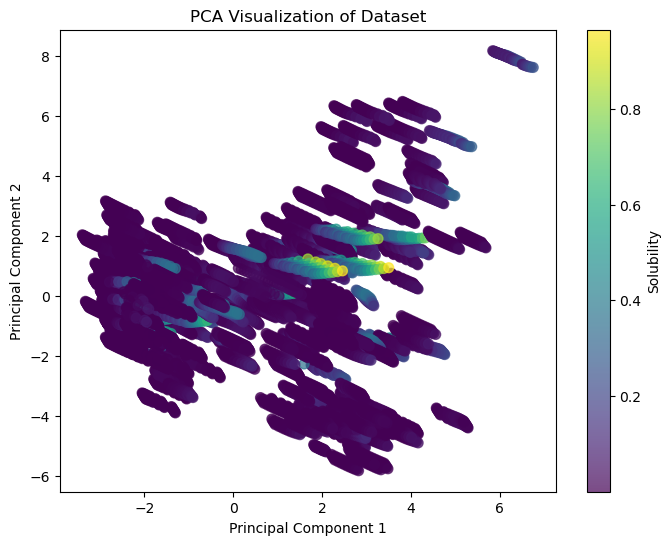

In [118]:
# PCA for visualization
features = [col for col in data.columns if col not in ['Solvent_1', 'Solvent_2', 'Solvent', 'solubility', 'Drug', 'SMILES', 'Solvent_solvent1', 'SMILES_solvent1', 'Solvent_solvent2', 'SMILES_solvent2']]
X = data_numeric[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data['Solubility (mol/mol)'], cmap='viridis', s=50, alpha=0.7)
plt.colorbar(label='Solubility')
plt.title('PCA Visualization of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



Random Forest Test RMSE: 0.000, R2: 1.000
Gradient Boosting Test RMSE: 0.001, R2: 1.000


C:\Users\think\AppData\Local\Temp\ipykernel_73324\886717824.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')


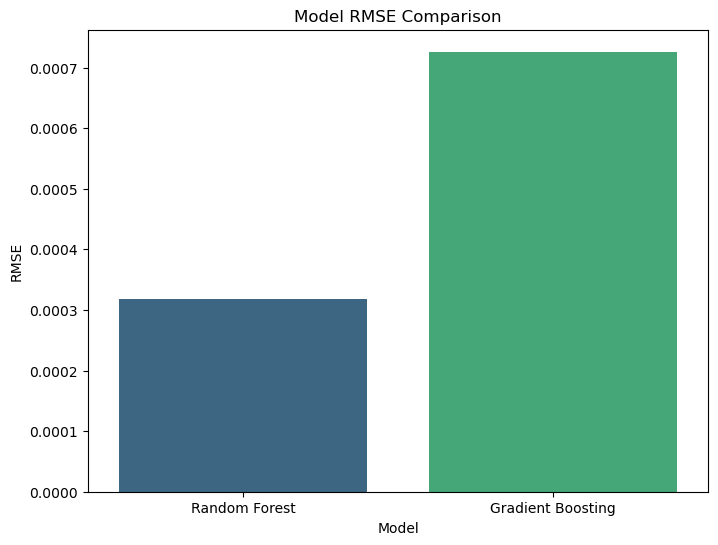

C:\Users\think\AppData\Local\Temp\ipykernel_73324\886717824.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')


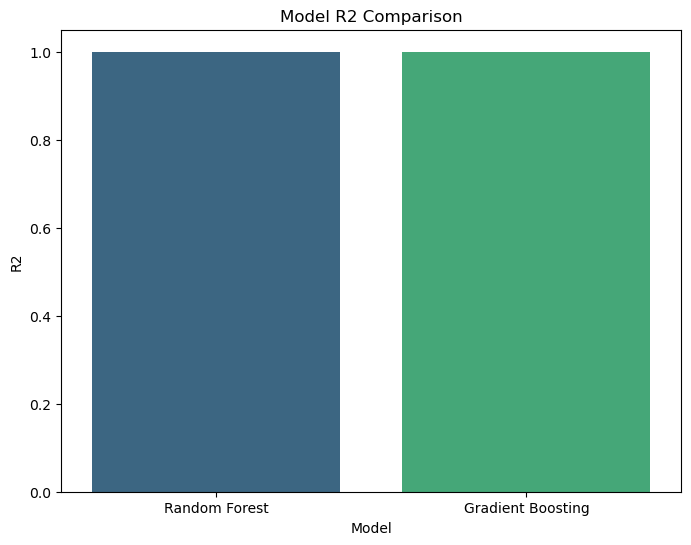

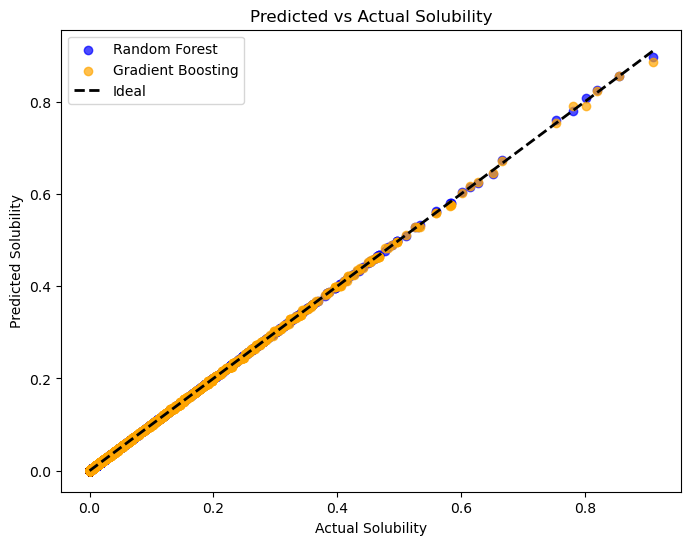

In [120]:
# Step 2: Baseline Model
# Prepare dataset
X = data[features]
y = data['Solubility (mol/mol)']

# Fill missing values
X = X.fillna(X.mean())

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

# Gradient Boosting Model
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
gb_preds = gb.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_preds))
gb_r2 = r2_score(y_test, gb_preds)

# Print Metrics
print(f"Random Forest Test RMSE: {rf_rmse:.3f}, R2: {rf_r2:.3f}")
print(f"Gradient Boosting Test RMSE: {gb_rmse:.3f}, R2: {gb_r2:.3f}")

# Training Logs Plot
results = {
    'Model': ['Random Forest', 'Gradient Boosting'],
    'RMSE': [rf_rmse, gb_rmse],
    'R2': [rf_r2, gb_r2]
}
results_df = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model RMSE Comparison')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='R2', data=results_df, palette='viridis')
plt.title('Model R2 Comparison')
plt.show()


# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds, alpha=0.7, label='Random Forest', color='blue')
plt.scatter(y_test, gb_preds, alpha=0.7, label='Gradient Boosting', color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.legend()
plt.title("Predicted vs Actual Solubility")
plt.show()

Mordred

In [28]:
import pandas as pd
import numpy as np
from mordred import Calculator, descriptors
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem

# Step 1: Load Data
solubility = pd.read_csv('solubility1.csv')
drugs = pd.read_csv('drugs1.csv')
solvents = pd.read_csv('solvents1.csv')

# Merge solubility with drugs and solvents
data = solubility.merge(drugs, left_on='Drug', right_on='Drug')
data = data.merge(solvents, left_on='Solvent_1', right_on='Solvent', suffixes=('_solvent1', '_solvent2'))
data = data.merge(solvents, left_on='Solvent_2', right_on='Solvent', suffixes=('', '_solvent2'))

# Featurize using Mordred
# Initialize Mordred calculator
calc = Calculator(descriptors, ignore_3D=True)

# Calculate Mordred features for drugs
def mordred_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return calc(mol)
    else:
        return None

# Generate Mordred features for drugs
mordred_drug_features = data['SMILES'].apply(mordred_features)
mordred_drug_features = pd.DataFrame(list(mordred_drug_features))

# Calculate ECFP fingerprints for drugs
def calculate_ecfp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    else:
        return np.zeros(n_bits)

data['ECFP'] = data['SMILES'].apply(lambda x: calculate_ecfp(x).tolist())

# Combine Mordred, ECFP, and experimental features
ecfp_features = pd.DataFrame(data['ECFP'].tolist())
drug_features = pd.concat([mordred_drug_features, ecfp_features], axis=1)

# Add solvent and experimental features
solvent_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']
X = pd.concat([
    drug_features,  # Drug features
    data[[f"{feat}_solvent1" for feat in solvent_features]],  # Solvent1 features
    data[[f"{feat}_solvent2" for feat in solvent_features]],  # Solvent2 features
    data[['Temperature']]  # Experimental conditions
], axis=1)

# Target variable
y = data['Solubility']

# Handle missing values (if any)
X = X.fillna(0)

# Normalize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train models
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

gbm_model = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gbm_model.fit(X_train, y_train)

# Model evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_gbm = gbm_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_r2 = r2_score(y_test, y_pred_rf)
gbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbm))
gbm_r2 = r2_score(y_test, y_pred_gbm)

print(f"Random Forest Test RMSE: {rf_rmse:.3f}, R2: {rf_r2:.3f}")
print(f"Gradient Boosting Test RMSE: {gbm_rmse:.3f}, R2: {gbm_r2:.3f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='Random Forest', color='blue')
plt.scatter(y_test, y_pred_gbm, alpha=0.7, label='Gradient Boosting', color='orange')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.legend()
plt.title("Predicted vs Actual Solubility")
plt.show()


ModuleNotFoundError: No module named 'mordred'

In [ ]:
DeepChem

In [ ]:
import pandas as pd
import numpy as np
import deepchem as dc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Load Data
solubility = pd.read_csv('solubility1.csv')
drugs = pd.read_csv('drugs1.csv')
solvents = pd.read_csv('solvents1.csv')

# Merge solubility with drugs and solvents
data = solubility.merge(drugs, left_on='Drug', right_on='Drug')
data = data.merge(solvents, left_on='Solvent_1', right_on='Solvent', suffixes=('_solvent1', '_solvent2'))
data = data.merge(solvents, left_on='Solvent_2', right_on='Solvent', suffixes=('', '_solvent2'))

# Featurize using DeepChem
# ConvMolFeaturizer for SMILES
featurizer = dc.feat.ConvMolFeaturizer()
X_drugs = featurizer.featurize(data['SMILES'])

# Solvent features can also be featurized, but here we'll use existing descriptors
solvent_features = ['MolWt', 'LogP', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumHAcceptors', 'NumAromaticRings']
X_solvent1 = data[[f"{feat}_solvent1" for feat in solvent_features]].values
X_solvent2 = data[[f"{feat}_solvent2" for feat in solvent_features]].values

# Combine features: Drug + Solvent1 + Solvent2 + Experimental conditions
X_combined = np.hstack([X_drugs, X_solvent1, X_solvent2, data[['Temperature']].values])

# Target variable
y = data['Solubility'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Build DeepChem model
n_tasks = 1  # Single regression task
model = dc.models.MultitaskRegressor(n_tasks=n_tasks, n_features=X_train.shape[1], layer_sizes=[128, 64], dropouts=0.1)

# Train model
model.fit(X_train, y_train, nb_epoch=50, batch_size=32)

# Predictions
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

# Metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {train_rmse:.3f}, R2: {train_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}, R2: {test_r2:.3f}")

# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2, label='Ideal')
plt.xlabel("Actual Solubility")
plt.ylabel("Predicted Solubility")
plt.legend()
plt.title("Predicted vs Actual Solubility")
plt.show()
